# Dependencies

In [1]:
!pip install lightning torchmetrics wandb
# pip install comet-ml
# !wandb login 6f34f7912bd3dd599707e44b5ef21252b0256056

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 kB 36.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.3/64.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: starlette
    Found existing installation: starlette 0.26.1
    Uninstalling starlette-0.26.1:
      Successfully uninstalled starlette-0.26.1
  Attempting uninstall: fastapi
    Found existing installation: fastapi 0.95.0
    Uninstalling fastapi-0.95.0:
      Successfully uninstalled fastapi-0.95.0


In [2]:
# import wandb
# import comet_ml
import torch
from os import cpu_count
from torch import nn, cat
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as T
from torchvision.transforms.functional import to_tensor, to_pil_image, resize
from torchvision.utils import make_grid
import torchvision.models as models
import lightning.pytorch as pl
from torchmetrics import StructuralSimilarityIndexMeasure
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Dataset

In [3]:
class NyuDataset(Dataset):
    def __init__(self, root, csv, apply_transforms=True):
        self.apply_transforms = apply_transforms
        with open(f'{root}{csv}') as f:
            self.samples = list(
                map(
                    lambda pair: list(
                        map(
                            lambda path: f'{root}{path}',
                            pair.strip().split(','),
                        )
                    ),
                    f.readlines(),
                )
            )

    def __getitem__(self, index):
        input_path, target_path = self.samples[index]
        input_image = Image.open(input_path).convert('RGB')
        target_image = Image.open(target_path).convert('L')
        x_tensor = to_tensor(input_image)
        y_tensor = to_tensor(target_image)
        # reduce the size to make the transforms less expensive
        x_tensor = resize(x_tensor, size=[224, 224], antialias=True)
        if self.apply_transforms:
            # reduce the targets to stack them later
            y_tensor = resize(y_tensor, size=[224, 224], antialias=True)
            input_image = T.ColorJitter()(input_image)
            t = T.Compose(
                [
                    T.RandomHorizontalFlip(),
                    T.Normalize(0, 1),
                ]
            )
        if self.apply_transforms:
            # stack and apply the same transformations to both
            tensors = cat([x_tensor, y_tensor])
            tensors = t(tensors)
            x_tensor = tensors[0:3]
            y_tensor = tensors[3:]
        y_tensor = resize(y_tensor, size=[56, 56], antialias=True)
        return x_tensor, y_tensor

    def __len__(self):
        return len(self.samples)

In [4]:
class NyuDataModule(pl.LightningDataModule):
    def __init__(self, root, csv_train, csv_test, batch_size: int = 32, apply_transforms=True):
        super().__init__()
        dataset = NyuDataset(root, csv_train, apply_transforms)
        self.test = NyuDataset(root, csv_test, apply_transforms)
        self.train, self.val = random_split(dataset, [0.8, 0.2])
        self.batch_size = batch_size
        self.workers = cpu_count()

    def train_dataloader(self):
        return DataLoader(
            self.train,
            batch_size=self.batch_size,
            num_workers=self.workers,
            shuffle=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.val,
            batch_size=self.batch_size,
            num_workers=self.workers,
            shuffle=False,
        )

    def test_dataloader(self):
        return DataLoader(
            self.test,
            batch_size=self.batch_size,
            num_workers=self.workers,
            shuffle=False,
        )


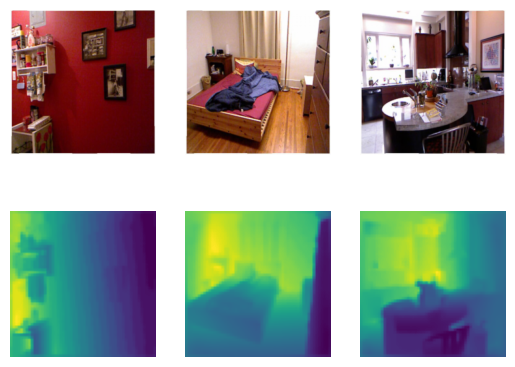

In [5]:
vis_data = NyuDataModule('/kaggle/input/nyu-depth-v2/nyu_data/', 'data/nyu2_train.csv', 'data/nyu2_test.csv',
                     batch_size=3, apply_transforms=True)
batch = next(iter(vis_data.train_dataloader()))
images, targets = batch
for (idx, (image, target)) in enumerate(zip(images, targets)):
  image = image.permute(1,2,0).numpy()
  target = target.permute(1,2,0).numpy()

  plt.subplot(2, 3, idx + 1)
  plt.imshow(image)
  plt.axis('off')

  plt.subplot(2, 3, idx + 4)
  plt.imshow(target)
  plt.axis('off')

# Model

In [6]:
class EfficientNetWrapper(pl.LightningModule):
    def __init__(self):
        super(EfficientNetWrapper, self).__init__()
        self.efficientnet = models.efficientnet_b0(
            weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1
        )
        self.base_layers = nn.Sequential(
            self.efficientnet.features[0],
            self.efficientnet.features[1],
            self.efficientnet.features[2],
        )
        self.layer1 = self.efficientnet.features[3]
        self.layer2 = nn.Sequential(
            self.efficientnet.features[4], self.efficientnet.features[5]
        )
        self.layer3 = self.efficientnet.features[6]
        self.layer4 = self.efficientnet.features[7]
        self.layer5 = self.efficientnet.features[8]

    def get_features(self, x):
        x = self.base_layers(x)
        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        x5 = self.layer5(x4)
        return x1, x2, x3, x4, x5

In [7]:
class BiFPN(nn.Module):
    def __init__(self, fpn_sizes):
        super(BiFPN, self).__init__()

        (
            P3_channels,
            P4_channels,
            P5_channels,
            P6_channels,
            P7_channels,
        ) = fpn_sizes
        self.W_bifpn = 64

        # self.p6_td_conv  = nn.Conv2d(P6_channels, self.W_bifpn, kernel_size=3, stride=1, groups=self.W_bifpn, bias=True, padding=1)
        self.p6_td_conv = nn.Conv2d(
            P6_channels,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            bias=True,
            padding=1,
        )
        self.p6_td_conv_2 = nn.Conv2d(
            self.W_bifpn,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            groups=self.W_bifpn,
            bias=True,
            padding=1,
        )
        self.p6_td_act = nn.GELU() # RELU
        self.p6_td_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p6_td_w1 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p6_td_w2 = torch.tensor(1, dtype=torch.float, requires_grad=True)

        self.p5_td_conv = nn.Conv2d(
            P5_channels,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            bias=True,
            padding=1,
        )
        self.p5_td_conv_2 = nn.Conv2d(
            self.W_bifpn,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            groups=self.W_bifpn,
            bias=True,
            padding=1,
        )
        self.p5_td_act = nn.GELU() # RELU
        self.p5_td_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p5_td_w1 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p5_td_w2 = torch.tensor(1, dtype=torch.float, requires_grad=True)

        self.p4_td_conv = nn.Conv2d(
            P4_channels,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            bias=True,
            padding=1,
        )
        self.p4_td_conv_2 = nn.Conv2d(
            self.W_bifpn,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            groups=self.W_bifpn,
            bias=True,
            padding=1,
        )
        self.p4_td_act = nn.GELU() # RELU
        self.p4_td_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p4_td_w1 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p4_td_w2 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p5_upsample = nn.Upsample(scale_factor=2, mode='nearest')

        self.p3_out_conv = nn.Conv2d(
            P3_channels,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            bias=True,
            padding=1,
        )
        self.p3_out_conv_2 = nn.Conv2d(
            self.W_bifpn,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            groups=self.W_bifpn,
            bias=True,
            padding=1,
        )
        self.p3_out_act = nn.GELU() # RELU
        self.p3_out_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p3_out_w1 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p3_out_w2 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p4_upsample = nn.Upsample(scale_factor=2, mode='nearest')

        # self.p4_out_conv = nn.Conv2d(P4_channels, self.W_bifpn, kernel_size=3, stride=1, bias=True, padding=1)
        self.p4_out_conv = nn.Conv2d(
            self.W_bifpn,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            groups=self.W_bifpn,
            bias=True,
            padding=1,
        )
        self.p4_out_act = nn.GELU() # RELU
        self.p4_out_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p4_out_w1 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p4_out_w2 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p4_out_w3 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p3_downsample = nn.MaxPool2d(kernel_size=2)

        # self.p5_out_conv = nn.Conv2d(P5_channels,self.W_bifpn, kernel_size=3, stride=1, bias=True, padding=1)
        self.p5_out_conv = nn.Conv2d(
            self.W_bifpn,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            groups=self.W_bifpn,
            bias=True,
            padding=1,
        )
        self.p5_out_act = nn.GELU() # RELU
        self.p5_out_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p5_out_w1 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p5_out_w2 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p5_out_w3 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p4_downsample = nn.MaxPool2d(kernel_size=2)

        # self.p6_out_conv = nn.Conv2d(P6_channels, self.W_bifpn, kernel_size=3, stride=1, bias=True, padding=1)
        self.p6_out_conv = nn.Conv2d(
            self.W_bifpn,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            groups=self.W_bifpn,
            bias=True,
            padding=1,
        )
        self.p6_out_act = nn.GELU() # RELU
        self.p6_out_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p6_out_w1 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p6_out_w2 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p6_out_w3 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        # self.p4_downsample= nn.MaxPool2d(kernel_size=2)

        self.p7_out_conv = nn.Conv2d(
            P7_channels,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            bias=True,
            padding=1,
        )
        self.p7_out_conv_2 = nn.Conv2d(
            self.W_bifpn,
            self.W_bifpn,
            kernel_size=3,
            stride=1,
            groups=self.W_bifpn,
            bias=True,
            padding=1,
        )
        self.p7_out_act = nn.GELU() # RELU
        self.p7_out_conv_bn = nn.BatchNorm2d(self.W_bifpn)
        self.p7_out_w1 = torch.tensor(1, dtype=torch.float, requires_grad=True)
        self.p7_out_w2 = torch.tensor(1, dtype=torch.float, requires_grad=True)

    def forward(self, inputs):
        epsilon = 0.0001
        P3, P4, P5, P6, P7 = inputs
        # print ("Input::", P3.shape, P4.shape, P5.shape, P6.shape, P7.shape)
        # P6_td = self.p6_td_conv((self.p6_td_w1 * P6 ) /
        #                         (self.p6_td_w1 + epsilon))

        P7_td = self.p7_out_conv(P7)

        P6_td_inp = self.p6_td_conv(P6)
        P6_td = self.p6_td_conv_2(
            (self.p6_td_w1 * P6_td_inp + self.p6_td_w2 * P7_td) / self.p6_td_w1
            + self.p6_td_w2
            + epsilon
        )
        # P6_td = self.p6_td_conv_2(P6_td_inp)
        P6_td = self.p6_td_act(P6_td)
        P6_td = self.p6_td_conv_bn(P6_td)

        P5_td_inp = self.p5_td_conv(P5)
        # print (P5_td_inp.shape, P6_td.shape)
        P5_td = self.p5_td_conv_2(
            (self.p5_td_w1 * P5_td_inp + self.p5_td_w2 * P6_td)
            / (self.p5_td_w1 + self.p5_td_w2 + epsilon)
        )
        P5_td = self.p5_td_act(P5_td)
        P5_td = self.p5_td_conv_bn(P5_td)

        # print (P4.shape, P5_td.shape)
        P4_td_inp = self.p4_td_conv(P4)
        P4_td = self.p4_td_conv_2(
            (
                self.p4_td_w1 * P4_td_inp
                + self.p4_td_w2 * self.p5_upsample(P5_td)
            )
            / (self.p4_td_w1 + self.p4_td_w2 + epsilon)
        )
        P4_td = self.p4_td_act(P4_td)
        P4_td = self.p4_td_conv_bn(P4_td)

        P3_td = self.p3_out_conv(P3)
        P3_out = self.p3_out_conv_2(
            (self.p3_out_w1 * P3_td + self.p3_out_w2 * self.p4_upsample(P4_td))
            / (self.p3_out_w1 + self.p3_out_w2 + epsilon)
        )
        P3_out = self.p3_out_act(P3_out)
        P3_out = self.p3_out_conv_bn(P3_out)

        # print (P4_td.shape, P3_out.shape)

        P4_out = self.p4_out_conv(
            (
                self.p4_out_w1 * P4_td_inp
                + self.p4_out_w2 * P4_td
                + self.p4_out_w3 * self.p3_downsample(P3_out)
            )
            / (self.p4_out_w1 + self.p4_out_w2 + self.p4_out_w3 + epsilon)
        )
        P4_out = self.p4_out_act(P4_out)
        P4_out = self.p4_out_conv_bn(P4_out)

        P5_out = self.p5_out_conv(
            (
                self.p5_out_w1 * P5_td_inp
                + self.p5_out_w2 * P5_td
                + self.p5_out_w3 * self.p4_downsample(P4_out)
            )
            / (self.p5_out_w2 + self.p5_out_w3 + epsilon)
        )
        P5_out = self.p5_out_act(P5_out)
        P5_out = self.p5_out_conv_bn(P5_out)

        P6_out = self.p6_out_conv(
            (
                self.p6_out_w1 * P6_td_inp
                + self.p6_out_w2 * P6_td
                + self.p6_out_w3 * (P5_out)
            )
            / (self.p6_out_w1 + self.p6_out_w2 + self.p6_out_w3 + epsilon)
        )
        P6_out = self.p6_out_act(P6_out)
        P6_out = self.p6_out_conv_bn(P6_out)

        P7_out = self.p7_out_conv_2(
            (self.p7_out_w1 * P7_td + self.p7_out_w2 * P6_out)
            / (self.p7_out_w1 + self.p7_out_w2 + epsilon)
        )
        P7_out = self.p7_out_act(P7_out)
        P7_out = self.p7_out_conv_bn(P7_out)

        return [P3_out, P4_out, P5_out, P6_out, P7_out]

In [8]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.bifpn = BiFPN([40, 112, 192, 320, 1280])
        self.upsample1 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=7, dilation=5, padding=1)
        self.upsample2 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=5, dilation=11, padding=1)
        self.bn = nn.BatchNorm2d(64)
        self.act = nn.GELU()

    def forward(self, x):
        x1, x2, _, _, _ = self.bifpn(x)
        x1 = self.upsample1(x1)
        x2 = self.upsample2(x2)
        x = torch.cat([x1, x2], 1)
        x = self.bn(x)
        x = self.act(x)
        return x

In [9]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, ks=3, act=True, dropout_prob=0.1):
        super().__init__()
        self.depth_conv = nn.Conv2d(in_channels, in_channels, kernel_size=ks, padding=ks//2, groups=in_channels, bias=False)
        self.point_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.identity_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.GELU() if act else None
        self.dropout = nn.Dropout2d(p=dropout_prob) if dropout_prob > 0 else None

    def forward(self, x):
        identity = x
        if self.identity_conv:
            identity = self.identity_conv(identity)
        x = self.depth_conv(x)
        x = self.point_conv(x)
        x = x + identity
        x += identity
        x = self.bn(x)
        if self.act:
            x = self.act(x)
        if self.dropout:
            x = self.dropout(x)
        return x

In [10]:
class DepthNet(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super().__init__()
        self.encoder = EfficientNetWrapper()
        self.encoder.freeze()
        self.d1 = Decoder()
        self.d2 = Decoder()
        self.d3 = Decoder()
        self.dropout = nn.Dropout2d(p=dropout_prob) if dropout_prob > 0 else None
        self.bn = nn.BatchNorm2d(192)
        self.head = nn.Sequential(
            ConvBlock(192, 160, ks=7),
            ConvBlock(160, 128, ks=5),
            ConvBlock(128, 96, ks=5),
            ConvBlock(96, 64),
            ConvBlock(64, 32),
            ConvBlock(32, 1, act=False)
        )
        self.act = nn.Sigmoid()

    def forward(self, x):
        x = self.encoder.get_features(x)
        x1 = self.d1(x)
        x2 = self.d2(x)
        x3 = self.d3(x)
        x = cat([x1, x2, x3], 1)
        if self.dropout:
            x = self.dropout(x)
        x = self.bn(x)
        x = self.head(x)
        x = self.act(x)
        return x

# Module definition

In [11]:
class LitDepth(pl.LightningModule):
    def __init__(self, learning_rate=2e-3): # weight_decay=1e-5
        super(LitDepth, self).__init__()
        self.save_hyperparameters()
        self.net = DepthNet()
        self.loss = torch.nn.MSELoss()
        self.accuracy = StructuralSimilarityIndexMeasure(data_range=1.0)

    def forward(self, x):
        x = self.net(x)
        return x

    def _do_stuff(self, batch, name):
        x, y = batch
        estimated = self(x)
        self.accuracy(estimated, y)
        self.log(f'{name}_acc', self.accuracy)
        loss = self.loss(estimated, y)
        self.log(f'{name}_loss', loss)
        return loss

    def training_step(self, batch, _batch_idx):
        return self._do_stuff(batch, 'train')

    def validation_step(self, batch, _batch_idx):
        return self._do_stuff(batch, 'validation')

    def test_step(self, batch, _batch_idx):
        return self._do_stuff(batch, 'test')

    def configure_optimizers(self):
        lr = self.hparams.learning_rate
        # wd = self.hparams.weight_decay
        optimizer = torch.optim.RAdam(self.parameters(), lr=lr) # weight_decay=wd)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(
            optimizer, gamma=0.9
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': scheduler,
            'monitor': 'validation_loss',
        }


# Training

## Image callback

In [12]:
class ImageSampler(pl.callbacks.Callback):
    def __init__(
        self,
        num_samples: int = 3,
        nrow: int = 8,
        padding: int = 2,
        normalize: bool = True,
        norm_range = None,
        scale_each: bool = False,
        pad_value: int = 0,
    ) -> None:
        """
        Args:
            num_samples: Number of images displayed in the grid. Default: ``3``.
            nrow: Number of images displayed in each row of the grid.
                The final grid size is ``(B / nrow, nrow)``. Default: ``8``.
            padding: Amount of padding. Default: ``2``.
            normalize: If ``True``, shift the image to the range (0, 1),
                by the min and max values specified by :attr:`range`. Default: ``False``.
            norm_range: Tuple (min, max) where min and max are numbers,
                then these numbers are used to normalize the image. By default, min and max
                are computed from the tensor.
            scale_each: If ``True``, scale each image in the batch of
                images separately rather than the (min, max) over all images. Default: ``False``.
            pad_value: Value for the padded pixels. Default: ``0``.
        """
        super().__init__()
        self.num_samples = num_samples
        self.nrow = nrow
        self.padding = padding
        self.normalize = normalize
        self.norm_range = norm_range
        self.scale_each = scale_each
        self.pad_value = pad_value
        
    def to_grid(self, images):
        return make_grid(
            tensor=images,
            nrow=self.nrow,
            padding=self.padding,
            normalize=self.normalize,
            range=self.norm_range,
            scale_each=self.scale_each,
            pad_value=self.pad_value,
        )

    def on_fit_start(self, trainer, pl_module):
        logger = pl_module.logger.experiment
        images, targets = next(iter(DataLoader(trainer.datamodule.val, batch_size=self.num_samples)))
        # image_grid = self.to_grid(images)
        # target_grid = self.to_grid(targets)
        logger.add_images("original images", images)
        logger.add_images("targets", targets)

    def on_validation_epoch_end(self, trainer, pl_module) -> None:
        logger = pl_module.logger.experiment
        images, targets = next(iter(DataLoader(trainer.datamodule.val, batch_size=self.num_samples)))
        # generate images
        estimated = pl_module(images.to(pl_module.device)).detach()
        # estimated_grid = to_pil_image(self.to_grid(estimated))
        logger.add_images("estimated depth", estimated, trainer.current_epoch)
        
    def on_test_epoch_end(self, trainer, pl_module) -> None:
        logger = pl_module.logger.experiment
        images, targets = next(iter(DataLoader(trainer.datamodule.test, batch_size=self.num_samples)))
        # generate images
        estimated = pl_module(images.to(pl_module.device)).detach()
        # estimated_grid = to_pil_image(self.to_grid(estimated))
        logger.add_images("test images", images)
        logger.add_images("test estimation", estimated)

## Experiment definitions

In [13]:
experiments = [{
    'name': 'low lr with augs',
    'lr': 2e-4,
    'augs': True
    },
    {
    'name': 'mid lr with augs',
    'lr': 2e-3,
    'augs': True
    },
    {
    'name': 'high lr with augs',
    'lr': 2e-2,
    'augs': True
    },
    {
    'name': 'without augs',
    'lr': 2e-3,
    'augs': False
}]

## Trainer Definition

In [14]:
def run_experiment(name, lr, augs):
    early_stop_callback = pl.callbacks.EarlyStopping(
      monitor='validation_loss',
      min_delta=1e-3,
      patience=4,
      verbose=True,
      mode='min'
    )

    checkpoint_callback = pl.callbacks.ModelCheckpoint(
        dirpath='/kaggle/working/models/',
        filename='best_model',
        save_top_k=1,
        verbose=True,
        monitor='validation_loss',
        mode='min',
    )

    image_callback = ImageSampler()

    tb_logger = pl.loggers.TensorBoardLogger(
        save_dir='/kaggle/working/',
        name='tb_logs',
        version=name
    )

    data = NyuDataModule(
        root='/kaggle/input/nyu-depth-v2/nyu_data/',
        csv_train='data/nyu2_train.csv',
        csv_test='data/nyu2_test.csv',
        batch_size=64,
        apply_transforms=augs
    )

    model = LitDepth(learning_rate = lr)

    trainer = pl.Trainer(
        accelerator='auto',
        default_root_dir='/kaggle/working/',
        callbacks=[
            early_stop_callback,
            checkpoint_callback,
            image_callback,
            pl.callbacks.LearningRateMonitor(),
            # pl.callbacks.StochasticWeightAveraging(swa_lrs=1e-3, device='cpu'),
            pl.callbacks.ModelSummary(),
        ],
        max_epochs=6,
        # limit_train_batches=0.25,
        # limit_test_batches=0.25,
        # limit_val_batches=0.25,
        precision='16-mixed',
        logger=tb_logger,
        gradient_clip_val=0.5,
        detect_anomaly=True,
        # fast_dev_run=True,
        # profiler="simple"
    )

    print('Starting training...')
    trainer.fit(model, datamodule=data)

    print('Starting testing...')
    trainer.test(model, datamodule=data)

    batch = next(iter(vis_data.test_dataloader()))
    images, targets = batch
    model.eval()
    model.freeze()
    for (idx, (image, _)) in enumerate(zip(images, targets)):
      est = model(image.unsqueeze(0)).detach().squeeze(0)
      est = est.permute(1,2,0).numpy()
      image = image.permute(1,2,0).numpy()

      plt.subplot(2, 3, idx + 1)
      plt.imshow(image)
      plt.axis('off')

      plt.subplot(2, 3, idx + 4)
      plt.imshow(est)
      plt.title(f'{name}: estimation')
      plt.axis('off')
      plt.show()
      plt.savefig(f'{name}.png')

# Runs

Running experiment: {'name': 'low lr with augs', 'lr': 0.0002, 'augs': True}


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 53.9MB/s]
INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs


Starting training...


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name     | Type                             | Params
--------------------------------------------------------------
0 | net      | DepthNet                         | 9.3 M 
1 | loss     | MSELoss                          | 0     
2 | accuracy | StructuralSimilarityIndexMeasure | 0     
--------------------------------------------------------------
4.0 M     Trainable params
5.3 M     Non-trainable params
9.3 M     Total params
37.146    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: Metric validation_loss improved. New best score: 0.039
INFO: Epoch 0, global step 634: 'validation_loss' reached 0.03919 (best 0.03919), saving model to '/kaggle/working/models/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Metric validation_loss improved by 0.008 >= min_delta = 0.001. New best score: 0.031
INFO: Epoch 1, global step 1268: 'validation_loss' reached 0.03096 (best 0.03096), saving model to '/kaggle/working/models/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Metric validation_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.025
INFO: Epoch 2, global step 1902: 'validation_loss' reached 0.02478 (best 0.02478), saving model to '/kaggle/working/models/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Metric validation_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.019
INFO: Epoch 3, global step 2536: 'validation_loss' reached 0.01889 (best 0.01889), saving model to '/kaggle/working/models/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Metric validation_loss improved by 0.004 >= min_delta = 0.001. New best score: 0.015
INFO: Epoch 4, global step 3170: 'validation_loss' reached 0.01535 (best 0.01535), saving model to '/kaggle/working/models/best_model.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Metric validation_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.014
INFO: Epoch 5, global step 3804: 'validation_loss' reached 0.01366 (best 0.01366), saving model to '/kaggle/working/models/best_model.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=6` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting testing...


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.5519980192184448     │
│         test_loss         │    0.4111258089542389     │
└───────────────────────────┴───────────────────────────┘

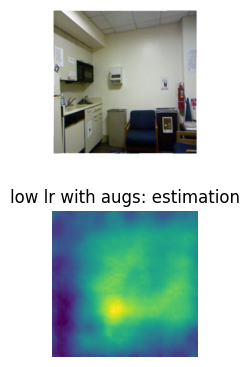

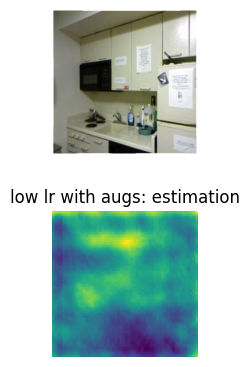

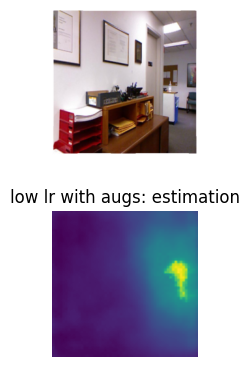

Running experiment: {'name': 'mid lr with augs', 'lr': 0.002, 'augs': True}


INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:612: UserWarning: Checkpoint directory /kaggle/working/models exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting training...


INFO: 
  | Name     | Type                             | Params
--------------------------------------------------------------
0 | net      | DepthNet                         | 9.3 M 
1 | loss     | MSELoss                          | 0     
2 | accuracy | StructuralSimilarityIndexMeasure | 0     
--------------------------------------------------------------
4.0 M     Trainable params
5.3 M     Non-trainable params
9.3 M     Total params
37.146    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: Metric validation_loss improved. New best score: 0.018
INFO: Epoch 0, global step 634: 'validation_loss' reached 0.01786 (best 0.01786), saving model to '/kaggle/working/models/best_model-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Metric validation_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.006
INFO: Epoch 1, global step 1268: 'validation_loss' reached 0.00608 (best 0.00608), saving model to '/kaggle/working/models/best_model-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Metric validation_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.004
INFO: Epoch 2, global step 1902: 'validation_loss' reached 0.00390 (best 0.00390), saving model to '/kaggle/working/models/best_model-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Metric validation_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.003
INFO: Epoch 3, global step 2536: 'validation_loss' reached 0.00287 (best 0.00287), saving model to '/kaggle/working/models/best_model-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 4, global step 3170: 'validation_loss' reached 0.00279 (best 0.00279), saving model to '/kaggle/working/models/best_model-v1.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 5, global step 3804: 'validation_loss' reached 0.00220 (best 0.00220), saving model to '/kaggle/working/models/best_model-v1.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=6` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting testing...


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4211477041244507     │
│         test_loss         │    0.5362389087677002     │
└───────────────────────────┴───────────────────────────┘

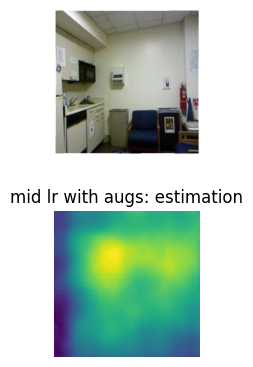

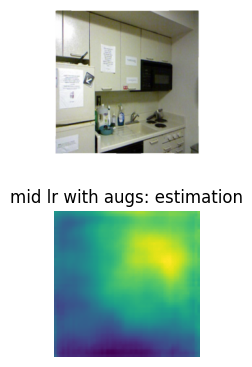

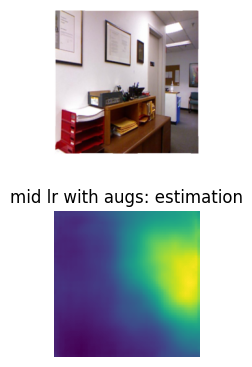

Running experiment: {'name': 'high lr with augs', 'lr': 0.02, 'augs': True}


INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting training...


INFO: 
  | Name     | Type                             | Params
--------------------------------------------------------------
0 | net      | DepthNet                         | 9.3 M 
1 | loss     | MSELoss                          | 0     
2 | accuracy | StructuralSimilarityIndexMeasure | 0     
--------------------------------------------------------------
4.0 M     Trainable params
5.3 M     Non-trainable params
9.3 M     Total params
37.146    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: Metric validation_loss improved. New best score: 0.006
INFO: Epoch 0, global step 634: 'validation_loss' reached 0.00581 (best 0.00581), saving model to '/kaggle/working/models/best_model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Metric validation_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.003
INFO: Epoch 1, global step 1268: 'validation_loss' reached 0.00347 (best 0.00347), saving model to '/kaggle/working/models/best_model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 2, global step 1902: 'validation_loss' reached 0.00299 (best 0.00299), saving model to '/kaggle/working/models/best_model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 3, global step 2536: 'validation_loss' reached 0.00294 (best 0.00294), saving model to '/kaggle/working/models/best_model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 4, global step 3170: 'validation_loss' reached 0.00248 (best 0.00248), saving model to '/kaggle/working/models/best_model-v2.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Metric validation_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.002
INFO: Epoch 5, global step 3804: 'validation_loss' reached 0.00226 (best 0.00226), saving model to '/kaggle/working/models/best_model-v2.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=6` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting testing...


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4239864945411682     │
│         test_loss         │     0.522158682346344     │
└───────────────────────────┴───────────────────────────┘

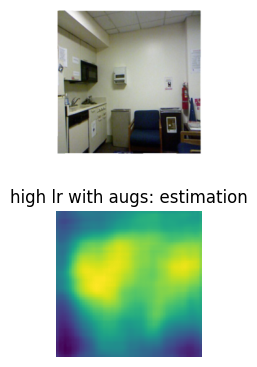

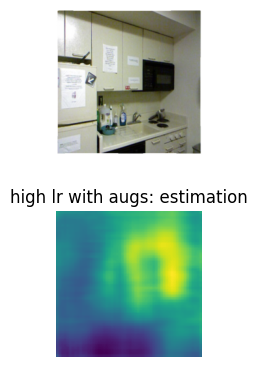

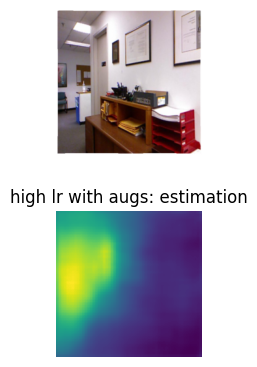

Running experiment: {'name': 'without augs', 'lr': 0.002, 'augs': False}


INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO: Trainer already configured with model summary callbacks: [<class 'lightning.pytorch.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting training...


INFO: 
  | Name     | Type                             | Params
--------------------------------------------------------------
0 | net      | DepthNet                         | 9.3 M 
1 | loss     | MSELoss                          | 0     
2 | accuracy | StructuralSimilarityIndexMeasure | 0     
--------------------------------------------------------------
4.0 M     Trainable params
5.3 M     Non-trainable params
9.3 M     Total params
37.146    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO: Metric validation_loss improved. New best score: 0.016
INFO: Epoch 0, global step 634: 'validation_loss' reached 0.01589 (best 0.01589), saving model to '/kaggle/working/models/best_model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Metric validation_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.005
INFO: Epoch 1, global step 1268: 'validation_loss' reached 0.00463 (best 0.00463), saving model to '/kaggle/working/models/best_model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Metric validation_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.003
INFO: Epoch 2, global step 1902: 'validation_loss' reached 0.00339 (best 0.00339), saving model to '/kaggle/working/models/best_model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 3, global step 2536: 'validation_loss' was not in top 1


Validation: 0it [00:00, ?it/s]

INFO: Epoch 4, global step 3170: 'validation_loss' reached 0.00244 (best 0.00244), saving model to '/kaggle/working/models/best_model-v3.ckpt' as top 1


Validation: 0it [00:00, ?it/s]

INFO: Metric validation_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.002
INFO: Epoch 5, global step 3804: 'validation_loss' reached 0.00216 (best 0.00216), saving model to '/kaggle/working/models/best_model-v3.ckpt' as top 1
INFO: `Trainer.fit` stopped: `max_epochs=6` reached.
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting testing...


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.4311382472515106     │
│         test_loss         │    0.5238679051399231     │
└───────────────────────────┴───────────────────────────┘

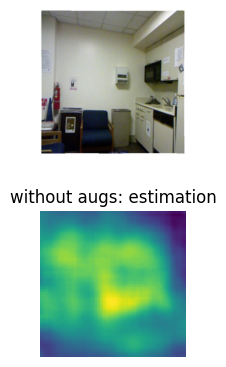

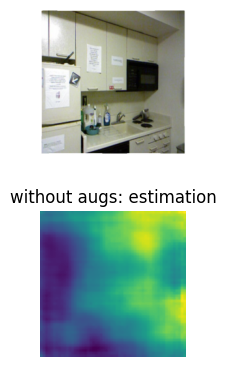

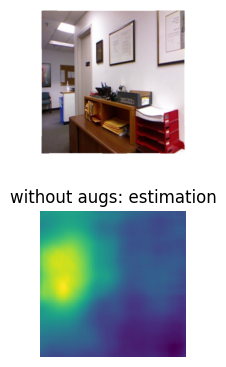

<Figure size 640x480 with 0 Axes>

In [15]:
for exp in experiments:
    print('Running experiment:', exp)
    run_experiment(**exp)